In [340]:
import dgl
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
import espaloma as esp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
! git pull

Already up to date.


In [114]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [117]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

In [118]:
states = []
losses = []

In [119]:
for _ in range(100):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n2'].data['u_ref'],
            g.nodes['n2'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        # print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n2'] for param in ['k', 'eq']
        }
    )

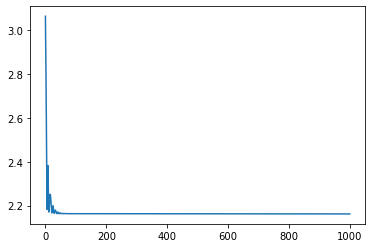

In [81]:
plt.plot(losses)

In [121]:
ks = np.array([state['n2_k'].flatten() for state in states])
eqs = np.array([state['n2_eq'].flatten() for state in states])

In [122]:
eqs.std(axis=0)

array([0.01283919, 0.0579662 , 0.07568979, 0.05640493, 0.01283919,
       0.0579662 , 0.07568979, 0.05640493], dtype=float32)

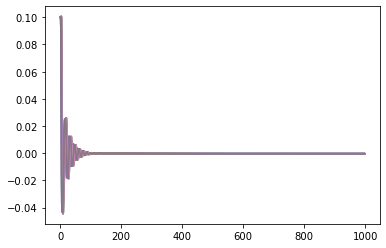

In [123]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

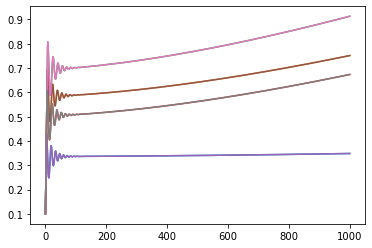

In [128]:
for idx in range(8):
    plt.plot(eqs[:, idx])

In [129]:
g.nodes['n2'].data['eq_ref']

tensor([[0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090]])

Text(0, 0.5, 'pred')

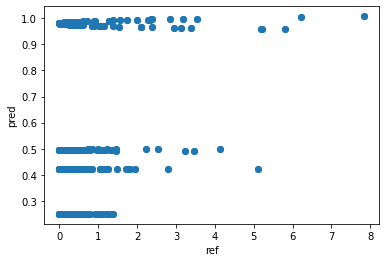

In [47]:
from matplotlib import pyplot as plt
plt.scatter(
    g.nodes['n2'].data['u_ref'].detach(),
    g.nodes['n2'].data['u'].detach()
)

plt.xlabel('ref')
plt.ylabel('pred')

# init at answer

In [187]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [188]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)


for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        setattr(
            representation, '%s_%s' % (term, param),
            torch.nn.Parameter(
                g.nodes[term].data[param + '_ref'].data
            )
        
        )
        
net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

In [148]:
list(net.named_parameters())

[('0.n1_epsilon',
  Parameter containing:
  tensor([[0.],
          [0.],
          [0.],
          [0.],
          [0.]], requires_grad=True)),
 ('0.n1_sigma',
  Parameter containing:
  tensor([[0.],
          [0.],
          [0.],
          [0.],
          [0.]], requires_grad=True)),
 ('0.n2_k',
  Parameter containing:
  tensor([[284512.],
          [284512.],
          [284512.],
          [284512.],
          [284512.],
          [284512.],
          [284512.],
          [284512.]], requires_grad=True)),
 ('0.n2_eq',
  Parameter containing:
  tensor([[0.1090],
          [0.1090],
          [0.1090],
          [0.1090],
          [0.1090],
          [0.1090],
          [0.1090],
          [0.1090]], requires_grad=True)),
 ('0.n3_k',
  Parameter containing:
  tensor([[292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
          [292.8800],
         

In [189]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [190]:
states = []
losses = []

In [191]:
def l():
    net(g.heterograph)

    loss = torch.nn.MSELoss()(
        g.nodes['n2'].data['u_ref'],
        g.nodes['n2'].data['u'],
    )

    loss = loss.sum()

    losses.append(loss.detach().numpy())

    # loss.backward()

    print(loss)
    return loss

l()
# optimizer.step(l)

tensor(0., grad_fn=<SumBackward0>)


tensor(0., grad_fn=<SumBackward0>)

In [192]:
g.nodes['n2'].data['k']

Parameter containing:
tensor([[284512.],
        [284512.],
        [284512.],
        [284512.],
        [284512.],
        [284512.],
        [284512.],
        [284512.]], requires_grad=True)

In [193]:
for _ in range(100):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n2'].data['u_ref'],
            g.nodes['n2'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n2'] for param in ['k', 'eq']
        }
    )

tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<

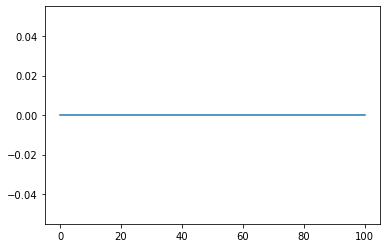

In [194]:
plt.plot(losses)

In [195]:
ks = np.array([state['n2_k'].flatten() for state in states])
eqs = np.array([state['n2_eq'].flatten() for state in states])

In [196]:
eqs.std(axis=0)

array([1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07,
       1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07],
      dtype=float32)

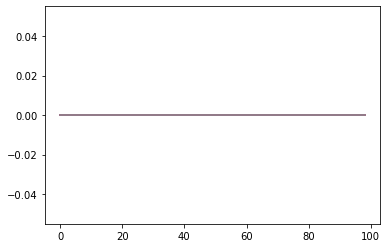

In [197]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

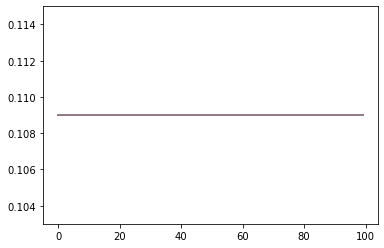

In [198]:
for idx in range(8):
    plt.plot(eqs[:, idx])

In [199]:
g.nodes['n2'].data['eq_ref']

tensor([[0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090],
        [0.1090]])

# param gaussian noise

In [227]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [228]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

epsilon = 0.1

for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        setattr(
            representation, '%s_%s' % (term, param),
            torch.nn.Parameter(
                g.nodes[term].data[param + '_ref'].data
                + torch.distributions.normal.Normal(
                    loc=torch.zeros_like(g.nodes[term].data[param + '_ref']),
                    scale=epsilon * torch.ones_like(g.nodes[term].data[param + '_ref']),
                ).sample()
            )
        
        )
        
net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

In [229]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [230]:
states = []
losses = []

In [231]:
def l():
    net(g.heterograph)

    loss = torch.nn.MSELoss()(
        g.nodes['n2'].data['u_ref'],
        g.nodes['n2'].data['u'],
    )

    loss = loss.sum()

    losses.append(loss.detach().numpy())

    # loss.backward()

    print(loss)
    return loss

l()
# optimizer.step(l)

tensor(6.1038e+09, grad_fn=<SumBackward0>)


tensor(6.1038e+09, grad_fn=<SumBackward0>)

In [232]:
g.nodes['n2'].data['k']

Parameter containing:
tensor([[284512.5312],
        [284512.2812],
        [284511.6250],
        [284512.2812],
        [284511.7812],
        [284514.7500],
        [284510.5938],
        [284510.2188]], requires_grad=True)

In [235]:
for _ in range(1000):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n2'].data['u_ref'],
            g.nodes['n2'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n2'] for param in ['k', 'eq']
        }
    )

tensor(100.8446, grad_fn=<SumBackward0>)
tensor(100.6872, grad_fn=<SumBackward0>)
tensor(100.5300, grad_fn=<SumBackward0>)
tensor(100.3729, grad_fn=<SumBackward0>)
tensor(100.2163, grad_fn=<SumBackward0>)
tensor(100.0600, grad_fn=<SumBackward0>)
tensor(99.9038, grad_fn=<SumBackward0>)
tensor(99.7481, grad_fn=<SumBackward0>)
tensor(99.5926, grad_fn=<SumBackward0>)
tensor(99.4373, grad_fn=<SumBackward0>)
tensor(99.2822, grad_fn=<SumBackward0>)
tensor(99.1276, grad_fn=<SumBackward0>)
tensor(98.9731, grad_fn=<SumBackward0>)
tensor(98.8189, grad_fn=<SumBackward0>)
tensor(98.6651, grad_fn=<SumBackward0>)
tensor(98.5115, grad_fn=<SumBackward0>)
tensor(98.3581, grad_fn=<SumBackward0>)
tensor(98.2052, grad_fn=<SumBackward0>)
tensor(98.0525, grad_fn=<SumBackward0>)
tensor(97.8999, grad_fn=<SumBackward0>)
tensor(97.7478, grad_fn=<SumBackward0>)
tensor(97.5960, grad_fn=<SumBackward0>)
tensor(97.4442, grad_fn=<SumBackward0>)
tensor(97.2928, grad_fn=<SumBackward0>)
tensor(97.1417, grad_fn=<SumBackwa

tensor(72.1276, grad_fn=<SumBackward0>)
tensor(72.0205, grad_fn=<SumBackward0>)
tensor(71.9137, grad_fn=<SumBackward0>)
tensor(71.8070, grad_fn=<SumBackward0>)
tensor(71.7005, grad_fn=<SumBackward0>)
tensor(71.5941, grad_fn=<SumBackward0>)
tensor(71.4880, grad_fn=<SumBackward0>)
tensor(71.3820, grad_fn=<SumBackward0>)
tensor(71.2762, grad_fn=<SumBackward0>)
tensor(71.1705, grad_fn=<SumBackward0>)
tensor(71.0652, grad_fn=<SumBackward0>)
tensor(70.9600, grad_fn=<SumBackward0>)
tensor(70.8549, grad_fn=<SumBackward0>)
tensor(70.7499, grad_fn=<SumBackward0>)
tensor(70.6452, grad_fn=<SumBackward0>)
tensor(70.5407, grad_fn=<SumBackward0>)
tensor(70.4363, grad_fn=<SumBackward0>)
tensor(70.3321, grad_fn=<SumBackward0>)
tensor(70.2281, grad_fn=<SumBackward0>)
tensor(70.1243, grad_fn=<SumBackward0>)
tensor(70.0207, grad_fn=<SumBackward0>)
tensor(69.9171, grad_fn=<SumBackward0>)
tensor(69.8139, grad_fn=<SumBackward0>)
tensor(69.7108, grad_fn=<SumBackward0>)
tensor(69.6078, grad_fn=<SumBackward0>)


tensor(51.9743, grad_fn=<SumBackward0>)
tensor(51.9007, grad_fn=<SumBackward0>)
tensor(51.8273, grad_fn=<SumBackward0>)
tensor(51.7539, grad_fn=<SumBackward0>)
tensor(51.6808, grad_fn=<SumBackward0>)
tensor(51.6078, grad_fn=<SumBackward0>)
tensor(51.5348, grad_fn=<SumBackward0>)
tensor(51.4619, grad_fn=<SumBackward0>)
tensor(51.3891, grad_fn=<SumBackward0>)
tensor(51.3166, grad_fn=<SumBackward0>)
tensor(51.2442, grad_fn=<SumBackward0>)
tensor(51.1718, grad_fn=<SumBackward0>)
tensor(51.0995, grad_fn=<SumBackward0>)
tensor(51.0274, grad_fn=<SumBackward0>)
tensor(50.9555, grad_fn=<SumBackward0>)
tensor(50.8836, grad_fn=<SumBackward0>)
tensor(50.8118, grad_fn=<SumBackward0>)
tensor(50.7400, grad_fn=<SumBackward0>)
tensor(50.6686, grad_fn=<SumBackward0>)
tensor(50.5972, grad_fn=<SumBackward0>)
tensor(50.5259, grad_fn=<SumBackward0>)
tensor(50.4546, grad_fn=<SumBackward0>)
tensor(50.3835, grad_fn=<SumBackward0>)
tensor(50.3126, grad_fn=<SumBackward0>)
tensor(50.2417, grad_fn=<SumBackward0>)


tensor(38.2614, grad_fn=<SumBackward0>)
tensor(38.2095, grad_fn=<SumBackward0>)
tensor(38.1577, grad_fn=<SumBackward0>)
tensor(38.1059, grad_fn=<SumBackward0>)
tensor(38.0543, grad_fn=<SumBackward0>)
tensor(38.0027, grad_fn=<SumBackward0>)
tensor(37.9512, grad_fn=<SumBackward0>)
tensor(37.8998, grad_fn=<SumBackward0>)
tensor(37.8485, grad_fn=<SumBackward0>)
tensor(37.7972, grad_fn=<SumBackward0>)
tensor(37.7461, grad_fn=<SumBackward0>)
tensor(37.6949, grad_fn=<SumBackward0>)
tensor(37.6439, grad_fn=<SumBackward0>)
tensor(37.5930, grad_fn=<SumBackward0>)
tensor(37.5421, grad_fn=<SumBackward0>)
tensor(37.4913, grad_fn=<SumBackward0>)
tensor(37.4406, grad_fn=<SumBackward0>)
tensor(37.3900, grad_fn=<SumBackward0>)
tensor(37.3394, grad_fn=<SumBackward0>)
tensor(37.2889, grad_fn=<SumBackward0>)
tensor(37.2385, grad_fn=<SumBackward0>)
tensor(37.1882, grad_fn=<SumBackward0>)
tensor(37.1379, grad_fn=<SumBackward0>)
tensor(37.0878, grad_fn=<SumBackward0>)
tensor(37.0377, grad_fn=<SumBackward0>)


tensor(28.8099, grad_fn=<SumBackward0>)
tensor(28.7723, grad_fn=<SumBackward0>)
tensor(28.7347, grad_fn=<SumBackward0>)
tensor(28.6971, grad_fn=<SumBackward0>)
tensor(28.6597, grad_fn=<SumBackward0>)
tensor(28.6222, grad_fn=<SumBackward0>)
tensor(28.5849, grad_fn=<SumBackward0>)
tensor(28.5476, grad_fn=<SumBackward0>)
tensor(28.5103, grad_fn=<SumBackward0>)
tensor(28.4731, grad_fn=<SumBackward0>)
tensor(28.4359, grad_fn=<SumBackward0>)
tensor(28.3989, grad_fn=<SumBackward0>)
tensor(28.3618, grad_fn=<SumBackward0>)
tensor(28.3248, grad_fn=<SumBackward0>)
tensor(28.2879, grad_fn=<SumBackward0>)
tensor(28.2510, grad_fn=<SumBackward0>)
tensor(28.2141, grad_fn=<SumBackward0>)
tensor(28.1774, grad_fn=<SumBackward0>)
tensor(28.1407, grad_fn=<SumBackward0>)
tensor(28.1040, grad_fn=<SumBackward0>)
tensor(28.0674, grad_fn=<SumBackward0>)
tensor(28.0309, grad_fn=<SumBackward0>)
tensor(27.9943, grad_fn=<SumBackward0>)
tensor(27.9579, grad_fn=<SumBackward0>)
tensor(27.9215, grad_fn=<SumBackward0>)


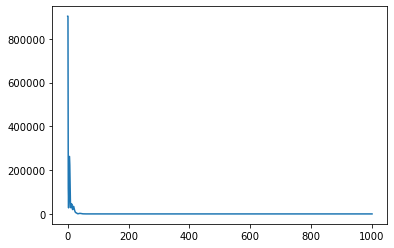

In [221]:
plt.plot(losses)

In [222]:
ks = np.array([state['n2_k'].flatten() for state in states])
eqs = np.array([state['n2_eq'].flatten() for state in states])

In [223]:
eqs.std(axis=0)

array([0.00861056, 0.00814728, 0.00960832, 0.00632757, 0.00632446,
       0.01258607, 0.00466169, 0.00619608], dtype=float32)

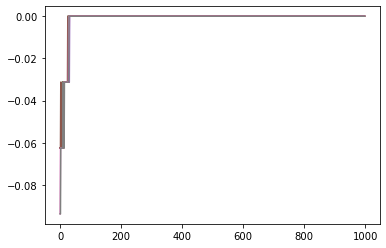

In [224]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

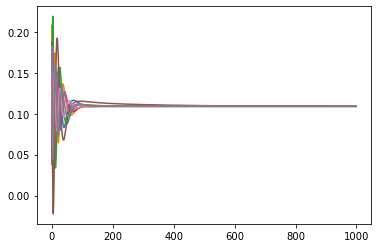

In [225]:
for idx in range(8):
    plt.plot(eqs[:, idx])

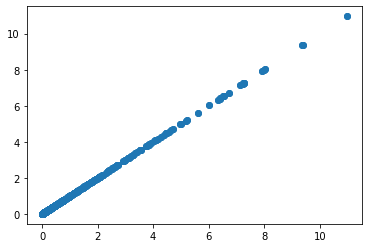

In [226]:
plt.scatter(
    g.nodes['n2'].data['u_ref'].flatten().detach(),
    g.nodes['n2'].data['u'].flatten().detach(),
)

# angle

In [236]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [237]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

epsilon = 0.1

for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        setattr(
            representation, '%s_%s' % (term, param),
            torch.nn.Parameter(
                g.nodes[term].data[param + '_ref'].data
                + torch.distributions.normal.Normal(
                    loc=torch.zeros_like(g.nodes[term].data[param + '_ref']),
                    scale=epsilon * torch.ones_like(g.nodes[term].data[param + '_ref']),
                ).sample()
            )
        
        )
        
net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

In [238]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [239]:
states = []
losses = []

In [240]:
def l():
    net(g.heterograph)

    loss = torch.nn.MSELoss()(
        g.nodes['n3'].data['u_ref'],
        g.nodes['n3'].data['u'],
    )

    loss = loss.sum()

    losses.append(loss.detach().numpy())

    # loss.backward()

    print(loss)
    return loss

l()
# optimizer.step(l)

tensor(2.7066, grad_fn=<SumBackward0>)


tensor(2.7066, grad_fn=<SumBackward0>)

In [242]:
g.nodes['n3'].data['k']

Parameter containing:
tensor([[292.9106],
        [292.9850],
        [292.9162],
        [292.8510],
        [292.8928],
        [292.9483],
        [293.0017],
        [292.8395],
        [292.8523],
        [292.6634],
        [292.8339],
        [292.7982]], requires_grad=True)

In [243]:
for _ in range(1000):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n3'].data['u_ref'],
            g.nodes['n3'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n3'] for param in ['k', 'eq']
        }
    )

tensor(2.7066, grad_fn=<SumBackward0>)
tensor(0.6792, grad_fn=<SumBackward0>)
tensor(0.7481, grad_fn=<SumBackward0>)
tensor(0.6864, grad_fn=<SumBackward0>)
tensor(0.7229, grad_fn=<SumBackward0>)
tensor(0.7926, grad_fn=<SumBackward0>)
tensor(0.7654, grad_fn=<SumBackward0>)
tensor(0.5990, grad_fn=<SumBackward0>)
tensor(0.3852, grad_fn=<SumBackward0>)
tensor(0.2431, grad_fn=<SumBackward0>)
tensor(0.1906, grad_fn=<SumBackward0>)
tensor(0.1998, grad_fn=<SumBackward0>)
tensor(0.2352, grad_fn=<SumBackward0>)
tensor(0.2554, grad_fn=<SumBackward0>)
tensor(0.2453, grad_fn=<SumBackward0>)
tensor(0.2181, grad_fn=<SumBackward0>)
tensor(0.1925, grad_fn=<SumBackward0>)
tensor(0.1779, grad_fn=<SumBackward0>)
tensor(0.1641, grad_fn=<SumBackward0>)
tensor(0.1361, grad_fn=<SumBackward0>)
tensor(0.0959, grad_fn=<SumBackward0>)
tensor(0.0630, grad_fn=<SumBackward0>)
tensor(0.0573, grad_fn=<SumBackward0>)
tensor(0.0773, grad_fn=<SumBackward0>)
tensor(0.0966, grad_fn=<SumBackward0>)
tensor(0.0901, grad_fn=<S

tensor(2.6951e-05, grad_fn=<SumBackward0>)
tensor(2.6775e-05, grad_fn=<SumBackward0>)
tensor(2.6599e-05, grad_fn=<SumBackward0>)
tensor(2.6425e-05, grad_fn=<SumBackward0>)
tensor(2.6252e-05, grad_fn=<SumBackward0>)
tensor(2.6080e-05, grad_fn=<SumBackward0>)
tensor(2.5909e-05, grad_fn=<SumBackward0>)
tensor(2.5739e-05, grad_fn=<SumBackward0>)
tensor(2.5570e-05, grad_fn=<SumBackward0>)
tensor(2.5401e-05, grad_fn=<SumBackward0>)
tensor(2.5234e-05, grad_fn=<SumBackward0>)
tensor(2.5068e-05, grad_fn=<SumBackward0>)
tensor(2.4903e-05, grad_fn=<SumBackward0>)
tensor(2.4739e-05, grad_fn=<SumBackward0>)
tensor(2.4577e-05, grad_fn=<SumBackward0>)
tensor(2.4415e-05, grad_fn=<SumBackward0>)
tensor(2.4254e-05, grad_fn=<SumBackward0>)
tensor(2.4094e-05, grad_fn=<SumBackward0>)
tensor(2.3934e-05, grad_fn=<SumBackward0>)
tensor(2.3776e-05, grad_fn=<SumBackward0>)
tensor(2.3619e-05, grad_fn=<SumBackward0>)
tensor(2.3463e-05, grad_fn=<SumBackward0>)
tensor(2.3307e-05, grad_fn=<SumBackward0>)
tensor(2.31

tensor(7.8568e-06, grad_fn=<SumBackward0>)
tensor(7.8156e-06, grad_fn=<SumBackward0>)
tensor(7.7745e-06, grad_fn=<SumBackward0>)
tensor(7.7338e-06, grad_fn=<SumBackward0>)
tensor(7.6935e-06, grad_fn=<SumBackward0>)
tensor(7.6535e-06, grad_fn=<SumBackward0>)
tensor(7.6136e-06, grad_fn=<SumBackward0>)
tensor(7.5743e-06, grad_fn=<SumBackward0>)
tensor(7.5352e-06, grad_fn=<SumBackward0>)
tensor(7.4965e-06, grad_fn=<SumBackward0>)
tensor(7.4581e-06, grad_fn=<SumBackward0>)
tensor(7.4199e-06, grad_fn=<SumBackward0>)
tensor(7.3820e-06, grad_fn=<SumBackward0>)
tensor(7.3445e-06, grad_fn=<SumBackward0>)
tensor(7.3072e-06, grad_fn=<SumBackward0>)
tensor(7.2703e-06, grad_fn=<SumBackward0>)
tensor(7.2336e-06, grad_fn=<SumBackward0>)
tensor(7.1972e-06, grad_fn=<SumBackward0>)
tensor(7.1612e-06, grad_fn=<SumBackward0>)
tensor(7.1254e-06, grad_fn=<SumBackward0>)
tensor(7.0899e-06, grad_fn=<SumBackward0>)
tensor(7.0548e-06, grad_fn=<SumBackward0>)
tensor(7.0198e-06, grad_fn=<SumBackward0>)
tensor(6.98

tensor(3.5846e-06, grad_fn=<SumBackward0>)
tensor(3.5739e-06, grad_fn=<SumBackward0>)
tensor(3.5634e-06, grad_fn=<SumBackward0>)
tensor(3.5528e-06, grad_fn=<SumBackward0>)
tensor(3.5423e-06, grad_fn=<SumBackward0>)
tensor(3.5318e-06, grad_fn=<SumBackward0>)
tensor(3.5214e-06, grad_fn=<SumBackward0>)
tensor(3.5111e-06, grad_fn=<SumBackward0>)
tensor(3.5008e-06, grad_fn=<SumBackward0>)
tensor(3.4906e-06, grad_fn=<SumBackward0>)
tensor(3.4804e-06, grad_fn=<SumBackward0>)
tensor(3.4702e-06, grad_fn=<SumBackward0>)
tensor(3.4601e-06, grad_fn=<SumBackward0>)
tensor(3.4500e-06, grad_fn=<SumBackward0>)
tensor(3.4399e-06, grad_fn=<SumBackward0>)
tensor(3.4299e-06, grad_fn=<SumBackward0>)
tensor(3.4200e-06, grad_fn=<SumBackward0>)
tensor(3.4101e-06, grad_fn=<SumBackward0>)
tensor(3.4003e-06, grad_fn=<SumBackward0>)
tensor(3.3905e-06, grad_fn=<SumBackward0>)
tensor(3.3808e-06, grad_fn=<SumBackward0>)
tensor(3.3711e-06, grad_fn=<SumBackward0>)
tensor(3.3614e-06, grad_fn=<SumBackward0>)
tensor(3.35

tensor(2.0741e-06, grad_fn=<SumBackward0>)
tensor(2.0691e-06, grad_fn=<SumBackward0>)
tensor(2.0640e-06, grad_fn=<SumBackward0>)
tensor(2.0590e-06, grad_fn=<SumBackward0>)
tensor(2.0540e-06, grad_fn=<SumBackward0>)
tensor(2.0490e-06, grad_fn=<SumBackward0>)
tensor(2.0440e-06, grad_fn=<SumBackward0>)
tensor(2.0391e-06, grad_fn=<SumBackward0>)
tensor(2.0341e-06, grad_fn=<SumBackward0>)
tensor(2.0292e-06, grad_fn=<SumBackward0>)
tensor(2.0243e-06, grad_fn=<SumBackward0>)
tensor(2.0194e-06, grad_fn=<SumBackward0>)
tensor(2.0145e-06, grad_fn=<SumBackward0>)
tensor(2.0096e-06, grad_fn=<SumBackward0>)
tensor(2.0047e-06, grad_fn=<SumBackward0>)
tensor(1.9998e-06, grad_fn=<SumBackward0>)
tensor(1.9950e-06, grad_fn=<SumBackward0>)
tensor(1.9902e-06, grad_fn=<SumBackward0>)
tensor(1.9853e-06, grad_fn=<SumBackward0>)
tensor(1.9805e-06, grad_fn=<SumBackward0>)
tensor(1.9757e-06, grad_fn=<SumBackward0>)
tensor(1.9709e-06, grad_fn=<SumBackward0>)
tensor(1.9661e-06, grad_fn=<SumBackward0>)
tensor(1.96

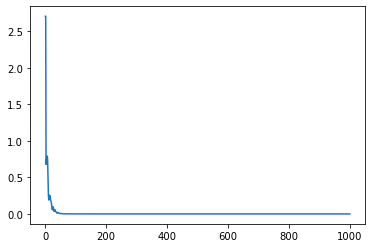

In [244]:
plt.plot(losses)

In [246]:
ks = np.array([state['n3_k'].flatten() for state in states])
eqs = np.array([state['n3_eq'].flatten() for state in states])

In [223]:
eqs.std(axis=0)

array([0.00861056, 0.00814728, 0.00960832, 0.00632757, 0.00632446,
       0.01258607, 0.00466169, 0.00619608], dtype=float32)

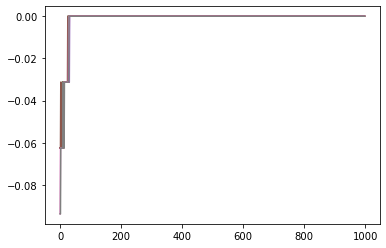

In [224]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

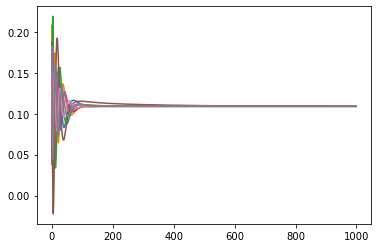

In [225]:
for idx in range(8):
    plt.plot(eqs[:, idx])

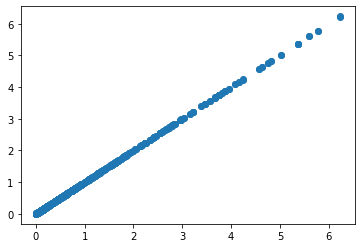

In [248]:
plt.scatter(
    g.nodes['n3'].data['u_ref'].flatten().detach(),
    g.nodes['n3'].data['u'].flatten().detach(),
)

# all

In [249]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [250]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

epsilon = 0.1

for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        setattr(
            representation, '%s_%s' % (term, param),
            torch.nn.Parameter(
                g.nodes[term].data[param + '_ref'].data
                + torch.distributions.normal.Normal(
                    loc=torch.zeros_like(g.nodes[term].data[param + '_ref']),
                    scale=epsilon * torch.ones_like(g.nodes[term].data[param + '_ref']),
                ).sample()
            )
        
        )
        
net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

In [251]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [252]:
states = []
losses = []

In [253]:
def l():
    net(g.heterograph)

    loss = torch.nn.MSELoss()(
        g.nodes['g'].data['u_ref'],
        g.nodes['g'].data['u'],
    )

    loss = loss.sum()

    losses.append(loss.detach().numpy())

    # loss.backward()

    print(loss)
    return loss

l()
# optimizer.step(l)

tensor(49389124., grad_fn=<SumBackward0>)


tensor(49389124., grad_fn=<SumBackward0>)

In [254]:
g.nodes['n3'].data['k']

Parameter containing:
tensor([[293.0371],
        [292.7313],
        [292.8307],
        [292.8486],
        [292.9033],
        [292.7491],
        [292.9083],
        [292.9725],
        [292.9128],
        [292.8771],
        [292.6192],
        [292.8592]], requires_grad=True)

In [255]:
for _ in range(1000):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n3'].data['u_ref'],
            g.nodes['n3'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n3'] for param in ['k', 'eq']
        }
    )

tensor(2.6912, grad_fn=<SumBackward0>)
tensor(0.9245, grad_fn=<SumBackward0>)
tensor(0.4158, grad_fn=<SumBackward0>)
tensor(0.5164, grad_fn=<SumBackward0>)
tensor(0.9526, grad_fn=<SumBackward0>)
tensor(1.0720, grad_fn=<SumBackward0>)
tensor(0.8110, grad_fn=<SumBackward0>)
tensor(0.4824, grad_fn=<SumBackward0>)
tensor(0.2885, grad_fn=<SumBackward0>)
tensor(0.2244, grad_fn=<SumBackward0>)
tensor(0.1977, grad_fn=<SumBackward0>)
tensor(0.1854, grad_fn=<SumBackward0>)
tensor(0.2200, grad_fn=<SumBackward0>)
tensor(0.2939, grad_fn=<SumBackward0>)
tensor(0.3473, grad_fn=<SumBackward0>)
tensor(0.3294, grad_fn=<SumBackward0>)
tensor(0.2444, grad_fn=<SumBackward0>)
tensor(0.1428, grad_fn=<SumBackward0>)
tensor(0.0727, grad_fn=<SumBackward0>)
tensor(0.0499, grad_fn=<SumBackward0>)
tensor(0.0617, grad_fn=<SumBackward0>)
tensor(0.0849, grad_fn=<SumBackward0>)
tensor(0.1037, grad_fn=<SumBackward0>)
tensor(0.1146, grad_fn=<SumBackward0>)
tensor(0.1168, grad_fn=<SumBackward0>)
tensor(0.1070, grad_fn=<S

tensor(2.4744e-05, grad_fn=<SumBackward0>)
tensor(2.4645e-05, grad_fn=<SumBackward0>)
tensor(2.4547e-05, grad_fn=<SumBackward0>)
tensor(2.4449e-05, grad_fn=<SumBackward0>)
tensor(2.4352e-05, grad_fn=<SumBackward0>)
tensor(2.4254e-05, grad_fn=<SumBackward0>)
tensor(2.4158e-05, grad_fn=<SumBackward0>)
tensor(2.4061e-05, grad_fn=<SumBackward0>)
tensor(2.3966e-05, grad_fn=<SumBackward0>)
tensor(2.3870e-05, grad_fn=<SumBackward0>)
tensor(2.3776e-05, grad_fn=<SumBackward0>)
tensor(2.3681e-05, grad_fn=<SumBackward0>)
tensor(2.3587e-05, grad_fn=<SumBackward0>)
tensor(2.3494e-05, grad_fn=<SumBackward0>)
tensor(2.3400e-05, grad_fn=<SumBackward0>)
tensor(2.3308e-05, grad_fn=<SumBackward0>)
tensor(2.3215e-05, grad_fn=<SumBackward0>)
tensor(2.3124e-05, grad_fn=<SumBackward0>)
tensor(2.3032e-05, grad_fn=<SumBackward0>)
tensor(2.2941e-05, grad_fn=<SumBackward0>)
tensor(2.2851e-05, grad_fn=<SumBackward0>)
tensor(2.2761e-05, grad_fn=<SumBackward0>)
tensor(2.2671e-05, grad_fn=<SumBackward0>)
tensor(2.25

tensor(1.1743e-05, grad_fn=<SumBackward0>)
tensor(1.1705e-05, grad_fn=<SumBackward0>)
tensor(1.1666e-05, grad_fn=<SumBackward0>)
tensor(1.1628e-05, grad_fn=<SumBackward0>)
tensor(1.1590e-05, grad_fn=<SumBackward0>)
tensor(1.1552e-05, grad_fn=<SumBackward0>)
tensor(1.1514e-05, grad_fn=<SumBackward0>)
tensor(1.1476e-05, grad_fn=<SumBackward0>)
tensor(1.1439e-05, grad_fn=<SumBackward0>)
tensor(1.1401e-05, grad_fn=<SumBackward0>)
tensor(1.1364e-05, grad_fn=<SumBackward0>)
tensor(1.1326e-05, grad_fn=<SumBackward0>)
tensor(1.1289e-05, grad_fn=<SumBackward0>)
tensor(1.1252e-05, grad_fn=<SumBackward0>)
tensor(1.1215e-05, grad_fn=<SumBackward0>)
tensor(1.1179e-05, grad_fn=<SumBackward0>)
tensor(1.1142e-05, grad_fn=<SumBackward0>)
tensor(1.1106e-05, grad_fn=<SumBackward0>)
tensor(1.1069e-05, grad_fn=<SumBackward0>)
tensor(1.1033e-05, grad_fn=<SumBackward0>)
tensor(1.0997e-05, grad_fn=<SumBackward0>)
tensor(1.0961e-05, grad_fn=<SumBackward0>)
tensor(1.0926e-05, grad_fn=<SumBackward0>)
tensor(1.08

tensor(6.1831e-06, grad_fn=<SumBackward0>)
tensor(6.1644e-06, grad_fn=<SumBackward0>)
tensor(6.1458e-06, grad_fn=<SumBackward0>)
tensor(6.1273e-06, grad_fn=<SumBackward0>)
tensor(6.1089e-06, grad_fn=<SumBackward0>)
tensor(6.0904e-06, grad_fn=<SumBackward0>)
tensor(6.0721e-06, grad_fn=<SumBackward0>)
tensor(6.0538e-06, grad_fn=<SumBackward0>)
tensor(6.0356e-06, grad_fn=<SumBackward0>)
tensor(6.0174e-06, grad_fn=<SumBackward0>)
tensor(5.9992e-06, grad_fn=<SumBackward0>)
tensor(5.9811e-06, grad_fn=<SumBackward0>)
tensor(5.9631e-06, grad_fn=<SumBackward0>)
tensor(5.9452e-06, grad_fn=<SumBackward0>)
tensor(5.9273e-06, grad_fn=<SumBackward0>)
tensor(5.9095e-06, grad_fn=<SumBackward0>)
tensor(5.8917e-06, grad_fn=<SumBackward0>)
tensor(5.8740e-06, grad_fn=<SumBackward0>)
tensor(5.8563e-06, grad_fn=<SumBackward0>)
tensor(5.8388e-06, grad_fn=<SumBackward0>)
tensor(5.8212e-06, grad_fn=<SumBackward0>)
tensor(5.8037e-06, grad_fn=<SumBackward0>)
tensor(5.7862e-06, grad_fn=<SumBackward0>)
tensor(5.76

tensor(3.3881e-06, grad_fn=<SumBackward0>)
tensor(3.3780e-06, grad_fn=<SumBackward0>)
tensor(3.3679e-06, grad_fn=<SumBackward0>)
tensor(3.3578e-06, grad_fn=<SumBackward0>)
tensor(3.3478e-06, grad_fn=<SumBackward0>)
tensor(3.3379e-06, grad_fn=<SumBackward0>)
tensor(3.3279e-06, grad_fn=<SumBackward0>)
tensor(3.3179e-06, grad_fn=<SumBackward0>)
tensor(3.3080e-06, grad_fn=<SumBackward0>)
tensor(3.2981e-06, grad_fn=<SumBackward0>)
tensor(3.2882e-06, grad_fn=<SumBackward0>)
tensor(3.2784e-06, grad_fn=<SumBackward0>)
tensor(3.2686e-06, grad_fn=<SumBackward0>)
tensor(3.2588e-06, grad_fn=<SumBackward0>)
tensor(3.2490e-06, grad_fn=<SumBackward0>)
tensor(3.2392e-06, grad_fn=<SumBackward0>)
tensor(3.2295e-06, grad_fn=<SumBackward0>)
tensor(3.2198e-06, grad_fn=<SumBackward0>)
tensor(3.2101e-06, grad_fn=<SumBackward0>)
tensor(3.2005e-06, grad_fn=<SumBackward0>)
tensor(3.1909e-06, grad_fn=<SumBackward0>)
tensor(3.1813e-06, grad_fn=<SumBackward0>)
tensor(3.1717e-06, grad_fn=<SumBackward0>)
tensor(3.16

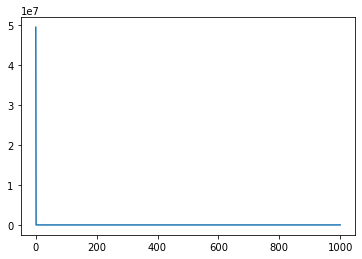

In [256]:
plt.plot(losses)

In [246]:
ks = np.array([state['n3_k'].flatten() for state in states])
eqs = np.array([state['n3_eq'].flatten() for state in states])

In [223]:
eqs.std(axis=0)

array([0.00861056, 0.00814728, 0.00960832, 0.00632757, 0.00632446,
       0.01258607, 0.00466169, 0.00619608], dtype=float32)

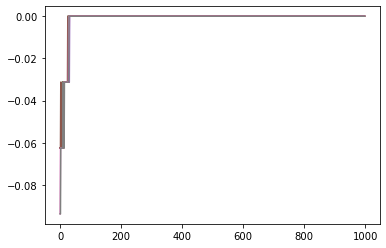

In [224]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

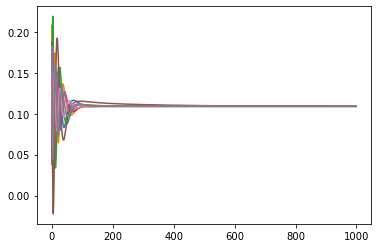

In [225]:
for idx in range(8):
    plt.plot(eqs[:, idx])

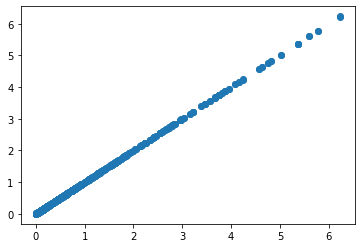

In [248]:
plt.scatter(
    g.nodes['n3'].data['u_ref'].flatten().detach(),
    g.nodes['n3'].data['u'].flatten().detach(),
)

# normalize

In [291]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [292]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

normalize = esp.data.normalize.ESOL100LogNormalNormalize()

epsilon = 0.1

for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        setattr(
            representation, '%s_%s' % (term, param),
            torch.nn.Parameter(
                torch.zeros_like(
                    g.nodes[term].data[param + '_ref'],
                )
                
            )
        
        )
        
net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

optimizer = torch.optim.Adam(
    net.parameters(),
    0.1,
)

# optimizer = torch.optim.LBFGS(
#     net.parameters(),
#     0.1,
#     line_search_fn='strong_wolfe',
# )

Warning (not error because allow_undefined_stereo=True): 
/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allow_undefined_stereo=True): 
Warning (not error because allo

In [293]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [294]:
states = []
losses = []

In [295]:
def l():
    net(g.heterograph)

    loss = torch.nn.MSELoss()(
        g.nodes['g'].data['u_ref'],
        g.nodes['g'].data['u'],
    )

    loss = loss.sum()

    losses.append(loss.detach().numpy())

    # loss.backward()

    print(loss)
    return loss

l()
# optimizer.step(l)

tensor(167.9672, grad_fn=<SumBackward0>)


tensor(167.9672, grad_fn=<SumBackward0>)

In [296]:
g.nodes['n3'].data['k']

Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)

In [297]:
for _ in range(1000):
    optimizer.zero_grad()
    
    def l():
        normalize.unnorm(net(g.heterograph))
        
        loss = torch.nn.MSELoss()(
            g.nodes['g'].data['u_ref'],
            g.nodes['g'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n3'] for param in ['k', 'eq']
        }
    )

tensor(167.9672, grad_fn=<SumBackward0>)
tensor(142.8859, grad_fn=<SumBackward0>)
tensor(116.7571, grad_fn=<SumBackward0>)
tensor(90.1148, grad_fn=<SumBackward0>)
tensor(64.6250, grad_fn=<SumBackward0>)
tensor(42.8339, grad_fn=<SumBackward0>)
tensor(28.2344, grad_fn=<SumBackward0>)
tensor(24.7820, grad_fn=<SumBackward0>)
tensor(33.4708, grad_fn=<SumBackward0>)
tensor(44.9448, grad_fn=<SumBackward0>)
tensor(49.3285, grad_fn=<SumBackward0>)
tensor(46.1321, grad_fn=<SumBackward0>)
tensor(39.1081, grad_fn=<SumBackward0>)
tensor(31.9728, grad_fn=<SumBackward0>)
tensor(26.9383, grad_fn=<SumBackward0>)
tensor(24.6497, grad_fn=<SumBackward0>)
tensor(24.6796, grad_fn=<SumBackward0>)
tensor(26.1241, grad_fn=<SumBackward0>)
tensor(28.0596, grad_fn=<SumBackward0>)
tensor(29.7834, grad_fn=<SumBackward0>)
tensor(30.8762, grad_fn=<SumBackward0>)
tensor(31.1713, grad_fn=<SumBackward0>)
tensor(30.6947, grad_fn=<SumBackward0>)
tensor(29.6093, grad_fn=<SumBackward0>)
tensor(28.1678, grad_fn=<SumBackward0

tensor(24.4151, grad_fn=<SumBackward0>)
tensor(24.4151, grad_fn=<SumBackward0>)
tensor(24.4150, grad_fn=<SumBackward0>)
tensor(24.4149, grad_fn=<SumBackward0>)
tensor(24.4149, grad_fn=<SumBackward0>)
tensor(24.4148, grad_fn=<SumBackward0>)
tensor(24.4147, grad_fn=<SumBackward0>)
tensor(24.4147, grad_fn=<SumBackward0>)
tensor(24.4146, grad_fn=<SumBackward0>)
tensor(24.4145, grad_fn=<SumBackward0>)
tensor(24.4145, grad_fn=<SumBackward0>)
tensor(24.4144, grad_fn=<SumBackward0>)
tensor(24.4143, grad_fn=<SumBackward0>)
tensor(24.4143, grad_fn=<SumBackward0>)
tensor(24.4142, grad_fn=<SumBackward0>)
tensor(24.4141, grad_fn=<SumBackward0>)
tensor(24.4141, grad_fn=<SumBackward0>)
tensor(24.4140, grad_fn=<SumBackward0>)
tensor(24.4139, grad_fn=<SumBackward0>)
tensor(24.4139, grad_fn=<SumBackward0>)
tensor(24.4138, grad_fn=<SumBackward0>)
tensor(24.4137, grad_fn=<SumBackward0>)
tensor(24.4137, grad_fn=<SumBackward0>)
tensor(24.4136, grad_fn=<SumBackward0>)
tensor(24.4135, grad_fn=<SumBackward0>)


tensor(24.4024, grad_fn=<SumBackward0>)
tensor(24.4023, grad_fn=<SumBackward0>)
tensor(24.4023, grad_fn=<SumBackward0>)
tensor(24.4022, grad_fn=<SumBackward0>)
tensor(24.4022, grad_fn=<SumBackward0>)
tensor(24.4021, grad_fn=<SumBackward0>)
tensor(24.4021, grad_fn=<SumBackward0>)
tensor(24.4020, grad_fn=<SumBackward0>)
tensor(24.4020, grad_fn=<SumBackward0>)
tensor(24.4019, grad_fn=<SumBackward0>)
tensor(24.4019, grad_fn=<SumBackward0>)
tensor(24.4018, grad_fn=<SumBackward0>)
tensor(24.4018, grad_fn=<SumBackward0>)
tensor(24.4017, grad_fn=<SumBackward0>)
tensor(24.4016, grad_fn=<SumBackward0>)
tensor(24.4016, grad_fn=<SumBackward0>)
tensor(24.4015, grad_fn=<SumBackward0>)
tensor(24.4015, grad_fn=<SumBackward0>)
tensor(24.4014, grad_fn=<SumBackward0>)
tensor(24.4014, grad_fn=<SumBackward0>)
tensor(24.4013, grad_fn=<SumBackward0>)
tensor(24.4013, grad_fn=<SumBackward0>)
tensor(24.4012, grad_fn=<SumBackward0>)
tensor(24.4012, grad_fn=<SumBackward0>)
tensor(24.4011, grad_fn=<SumBackward0>)


tensor(24.3925, grad_fn=<SumBackward0>)
tensor(24.3925, grad_fn=<SumBackward0>)
tensor(24.3924, grad_fn=<SumBackward0>)
tensor(24.3924, grad_fn=<SumBackward0>)
tensor(24.3923, grad_fn=<SumBackward0>)
tensor(24.3923, grad_fn=<SumBackward0>)
tensor(24.3923, grad_fn=<SumBackward0>)
tensor(24.3922, grad_fn=<SumBackward0>)
tensor(24.3922, grad_fn=<SumBackward0>)
tensor(24.3921, grad_fn=<SumBackward0>)
tensor(24.3921, grad_fn=<SumBackward0>)
tensor(24.3920, grad_fn=<SumBackward0>)
tensor(24.3920, grad_fn=<SumBackward0>)
tensor(24.3920, grad_fn=<SumBackward0>)
tensor(24.3919, grad_fn=<SumBackward0>)
tensor(24.3919, grad_fn=<SumBackward0>)
tensor(24.3918, grad_fn=<SumBackward0>)
tensor(24.3918, grad_fn=<SumBackward0>)
tensor(24.3917, grad_fn=<SumBackward0>)
tensor(24.3917, grad_fn=<SumBackward0>)
tensor(24.3917, grad_fn=<SumBackward0>)
tensor(24.3916, grad_fn=<SumBackward0>)
tensor(24.3916, grad_fn=<SumBackward0>)
tensor(24.3915, grad_fn=<SumBackward0>)
tensor(24.3915, grad_fn=<SumBackward0>)


tensor(24.3843, grad_fn=<SumBackward0>)
tensor(24.3842, grad_fn=<SumBackward0>)
tensor(24.3842, grad_fn=<SumBackward0>)
tensor(24.3842, grad_fn=<SumBackward0>)
tensor(24.3841, grad_fn=<SumBackward0>)
tensor(24.3841, grad_fn=<SumBackward0>)
tensor(24.3841, grad_fn=<SumBackward0>)
tensor(24.3840, grad_fn=<SumBackward0>)
tensor(24.3840, grad_fn=<SumBackward0>)
tensor(24.3839, grad_fn=<SumBackward0>)
tensor(24.3839, grad_fn=<SumBackward0>)
tensor(24.3839, grad_fn=<SumBackward0>)
tensor(24.3838, grad_fn=<SumBackward0>)
tensor(24.3838, grad_fn=<SumBackward0>)
tensor(24.3838, grad_fn=<SumBackward0>)
tensor(24.3837, grad_fn=<SumBackward0>)
tensor(24.3837, grad_fn=<SumBackward0>)
tensor(24.3837, grad_fn=<SumBackward0>)
tensor(24.3836, grad_fn=<SumBackward0>)
tensor(24.3836, grad_fn=<SumBackward0>)
tensor(24.3836, grad_fn=<SumBackward0>)
tensor(24.3835, grad_fn=<SumBackward0>)
tensor(24.3835, grad_fn=<SumBackward0>)
tensor(24.3835, grad_fn=<SumBackward0>)
tensor(24.3834, grad_fn=<SumBackward0>)


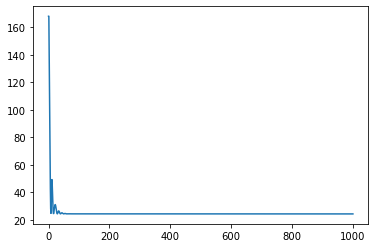

In [298]:
plt.plot(losses)

In [299]:
ks = np.array([state['n3_k'].flatten() for state in states])
eqs = np.array([state['n3_eq'].flatten() for state in states])

In [300]:
eqs.std(axis=0)

array([0.09075965, 0.03957924, 0.09163161, 0.09075965, 0.1489018 ,
       0.04383821, 0.03957924, 0.1489018 , 0.11702706, 0.09163161,
       0.04383821, 0.11702706], dtype=float32)

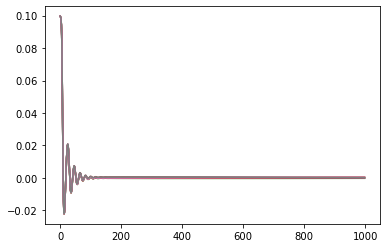

In [301]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

In [302]:
eqs

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07441369, -0.07441368, -0.07441368, ..., -0.07441368,
        -0.07441369, -0.07441369],
       [-0.15804487, -0.15804444, -0.1580455 , ..., -0.1580455 ,
        -0.15804446, -0.15804422],
       ...,
       [ 0.03205499, -0.25969642,  0.02677753, ...,  0.02677753,
        -0.22330615,  0.11207645],
       [ 0.03240395, -0.25987014,  0.02698839, ...,  0.02698839,
        -0.22294351,  0.11239401],
       [ 0.03275301, -0.26004395,  0.027199  , ...,  0.027199  ,
        -0.2225805 ,  0.11271118]], dtype=float32)

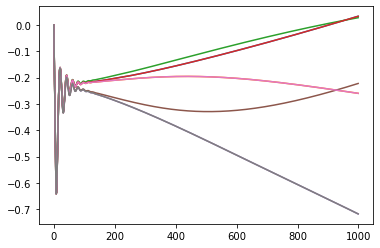

In [303]:
for idx in range(8):
    plt.plot(eqs[:, idx])

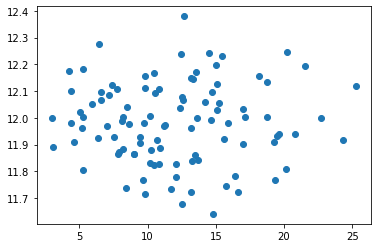

In [305]:
plt.scatter(
    g.nodes['g'].data['u_ref'].flatten().detach(),
    g.nodes['g'].data['u'].flatten().detach(),
)

# initialize clever

In [442]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [443]:
for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        print(term, param)
        print(g.nodes[term].data[param + '_ref'].mean())
        print(g.nodes[term].data[param + '_ref'].shape)
        



n2 k
tensor(284512.)
torch.Size([8, 1])
n2 eq
tensor(0.1090)
torch.Size([8, 1])
n3 k
tensor(292.8800)
torch.Size([12, 1])
n3 eq
tensor(1.9111)
torch.Size([12, 1])


In [444]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

representation.n2_k = torch.nn.Parameter(torch.ones(8, 1) * 200000.0)
representation.n2_eq = torch.nn.Parameter(torch.ones(8, 1) * 0.10)

representation.n3_k = torch.nn.Parameter(torch.ones(12, 1) * 200.)
representation.n3_eq = torch.nn.Parameter(torch.ones(12, 1) * 1.0)

net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

# optimizer = torch.optim.Adam(
#     net.parameters(),
#     0.1,
# )

optimizer = torch.optim.LBFGS(
    net.parameters(),
    0.1,
    line_search_fn='strong_wolfe',
)

In [445]:
print(net[0].n2_k)

Parameter containing:
tensor([[200000.],
        [200000.],
        [200000.],
        [200000.],
        [200000.],
        [200000.],
        [200000.],
        [200000.]], requires_grad=True)


In [446]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [447]:
states = []
losses = []

In [448]:
for _ in range(1000):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n2'].data['u_ref'],
            g.nodes['n2'].data['u'],
        )
        
        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n2'] for param in ['k', 'eq']
        }
    )

tensor(21.7946, grad_fn=<SumBackward0>)
tensor(1.1443, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(37.0632, grad_fn=<SumBackward0>)
tensor(2.4559, grad_fn=<SumBackward0>)
tensor(1.6552, grad_fn=<SumBackward0>)
tensor(1.4179, grad_fn=<SumBackward0>)
tensor(1.3248, grad_fn=<SumBackward0>)
tensor(1.2838, grad_fn=<SumBackward0>)
tensor(1.2646, grad_fn=<SumBackward0>)
tensor(1.2553, grad_fn=<SumBackward0>)
tensor(1.2506, grad_fn=<SumBackward0>)
tensor(1.2482, grad_fn=<SumBackward0>)
tensor(1.2470, grad_fn=<SumBackward0>)
tensor(1.2464, grad_fn=<SumBackward0>)
tensor(1.2460, grad_fn=<SumBackward0>)
tensor(1.2458, grad_fn=<SumBackward0>)
tensor(1.2457, grad_fn=<SumBackward0>)
tensor(1.2457, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=<SumBackward0>)
tensor(1.2456, grad_fn=

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<SumBackward0>)
tensor(0.0543, grad_fn=<S

KeyboardInterrupt: 

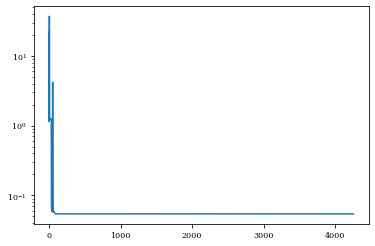

In [449]:
plt.plot(losses)
plt.yscale('log')

In [450]:
ks = np.array([state['n2_k'].flatten() for state in states])
eqs = np.array([state['n2_eq'].flatten() for state in states])

In [451]:
eqs.std(axis=0)

array([0.00012311, 0.00013883, 0.00015617, 0.00013445, 0.00012311,
       0.00013883, 0.00015617, 0.00013445], dtype=float32)

In [452]:
eqs

array([[0.11180202, 0.11274286, 0.11355009, ..., 0.11274286, 0.11355009,
        0.11240504],
       [0.10804342, 0.10865138, 0.10914824, ..., 0.10865138, 0.10914824,
        0.10842049],
       [0.10826028, 0.10874667, 0.1090595 , ..., 0.10874667, 0.1090595 ,
        0.10853494],
       ...,
       [0.10826689, 0.10874916, 0.10905708, ..., 0.10874916, 0.10905708,
        0.10853812],
       [0.10826689, 0.10874916, 0.10905708, ..., 0.10874916, 0.10905708,
        0.10853812],
       [0.10826689, 0.10874916, 0.10905708, ..., 0.10874916, 0.10905708,
        0.10853812]], dtype=float32)

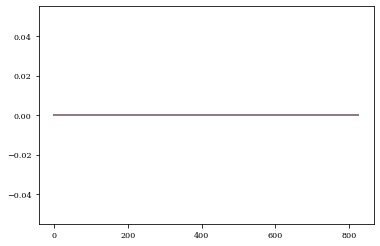

In [453]:
for idx in range(8):
    plt.plot(np.diff(ks[:, idx]))
    

In [454]:
eqs

array([[0.11180202, 0.11274286, 0.11355009, ..., 0.11274286, 0.11355009,
        0.11240504],
       [0.10804342, 0.10865138, 0.10914824, ..., 0.10865138, 0.10914824,
        0.10842049],
       [0.10826028, 0.10874667, 0.1090595 , ..., 0.10874667, 0.1090595 ,
        0.10853494],
       ...,
       [0.10826689, 0.10874916, 0.10905708, ..., 0.10874916, 0.10905708,
        0.10853812],
       [0.10826689, 0.10874916, 0.10905708, ..., 0.10874916, 0.10905708,
        0.10853812],
       [0.10826689, 0.10874916, 0.10905708, ..., 0.10874916, 0.10905708,
        0.10853812]], dtype=float32)

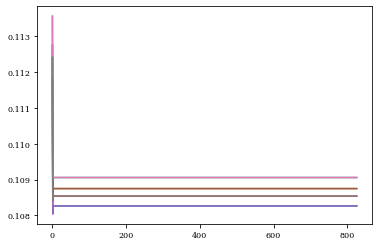

In [455]:
for idx in range(8):
    plt.plot(eqs[:, idx])

Text(0, 0.5, '$U_\\mathtt{pred}$')

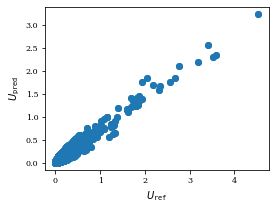

In [456]:

plt.rc('font', family='serif', size=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)



plt.scatter(
    g.nodes['n2'].data['u_ref'].flatten().detach(),
    g.nodes['n2'].data['u'].flatten().detach(),
)

plt.xlabel('$U_\mathtt{ref}$')
plt.ylabel('$U_\mathtt{pred}$')